In [1]:
import tensorflow as tf
from deeponet import DeepONet, CosineAnnealingSchedule
from utils import *
import matplotlib.pyplot as plt
from flow import Flow_v2
import numpy as np
import gc

2024-11-19 17:43:46.857820: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 17:43:46.909103: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def model_fn():
    model = DeepONet(
        n_branch = 64, 
        n_trunk = 2, 
        width = 100, 
        depth = 3, 
        output_dim = 100,
        activation = "relu",
        grid_size = (128, 128)
    )

    return model

def optimizer_fn():
    lr_schedule = CosineAnnealingSchedule(
        initial_learning_rate=0.001, 
        decay_steps=100,  
        alpha=0.0 
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    return optimizer


def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.reduce_sum(tf.square(y_true - y_pred), axis = 1), axis = 0)

In [3]:
dataloader = DarcyDatasetLoader("DarcyDataset")
train_dataset, test_dataset = dataloader.get_split(test_size = 0.2, batch_size = -1, frac = 0.8)

In [4]:
def downsample(a, u):
    a = tf.expand_dims(a, axis=-1) 
    a = tf.expand_dims(a, axis=0) 
    pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))

    a_downsampled = pooling_layer(a)
    a_downsampled = tf.squeeze(a_downsampled)

    return a_downsampled, u

In [5]:
train_dataset = train_dataset.map(lambda a, u : downsample(a, u/1e-2))
test_dataset  = test_dataset.map(lambda a, u : downsample(a, u/1e-2))

In [6]:
X_train = tf.convert_to_tensor(
    list(train_dataset.map(lambda a, u: a).as_numpy_iterator())
)
y_train = tf.convert_to_tensor(
    list(train_dataset.map(lambda a, u: tf.reshape(u, [-1])).as_numpy_iterator())
)

2024-11-19 17:43:53.651091: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-19 17:43:57.134374: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
def run_flow_experiments(N_MODELS, EPOCHS = 5_000, MEMORY_EPOCHS=[100, 500, 1000, 2500, 5000]) :

    for n_models in N_MODELS:

        flow = Flow_v2(
            model_fn = model_fn,
            n_models = n_models,
            noise_stddev=tf.cast(1e-4, tf.float32), 
            lam = tf.cast(1e0, tf.float32))

        flow.compile(
            optimizer_fn=optimizer_fn,
            loss_fn=loss_fn, 
            metrics=["mae"], 
        )

        flow.fit(
            x=X_train, 
            y=y_train, 
            epochs = EPOCHS, 
            batch_size = 128,
            # memory_epochs = [100, 500, 1000, 2500, 5000]
            memory_epochs = MEMORY_EPOCHS
        )

        est_IS = flow.get_estimator(name='importance_sampling')
        est_DP = flow.get_estimator(name='deep_ensemble')

        list_u_pred_IS, list_std_pred_IS = [], []
        list_u_pred_DP, list_std_pred_DP = [], []
        list_error_IS, list_error_DP               = [], []

        for (a, u) in test_dataset:
            u_pred_IS, std_pred_IS = est_IS(a[None, ...])
            u_pred_DP, std_pred_DP = est_DP(a[None, ...])

            error_IS = np.abs(u_pred_IS - tf.reshape(u, [-1]))**2 / np.max(tf.reshape(u, [-1])**2)
            error_DP = np.abs(u_pred_DP - tf.reshape(u, [-1]))**2 / np.max(tf.reshape(u, [-1])**2)

            list_u_pred_IS.append(u_pred_IS)
            list_std_pred_IS.append(std_pred_IS)
            
            list_u_pred_DP.append(u_pred_DP)
            list_std_pred_DP.append(std_pred_DP)

            list_error_IS.append(error_IS)
            list_error_DP.append(error_DP)



        list_u_pred_IS, list_std_pred_IS = np.array(list_u_pred_IS), np.array(list_std_pred_IS)
        list_u_pred_DP, list_std_pred_DP = np.array(list_u_pred_DP), np.array(list_std_pred_DP)
        list_error_IS, list_error_DP               = np.array(list_error_IS), np.array(list_error_DP)

        np.savez(f"results/{n_models}.npz", 
                u_pred_IS=list_u_pred_IS,
                std_pred_IS=list_std_pred_IS,
                u_pred_DP=list_u_pred_DP,
                std_pred_DP=list_std_pred_DP,
                error_IS=list_error_IS,
                error_DP= list_error_DP
                )

        del flow, est_IS, est_DP
        del list_u_pred_IS, list_std_pred_IS, list_u_pred_DP, list_std_pred_DP
        del list_error_IS, list_error_DP
        gc.collect()  # Trigger garbage collection

        print(f"==n_models = {n_models} Done!")

        

In [8]:
run_flow_experiments(N_MODELS=[1, 2], EPOCHS=3, MEMORY_EPOCHS = [1, 2, 3])

Epoch 1/3
50/50 - 8s - 152ms/step - loss: 1830.1143 - mae: 0.3261
Epoch 2/3
50/50 - 4s - 84ms/step - loss: 1285.1086 - mae: 0.2885
Epoch 3/3
50/50 - 4s - 86ms/step - loss: 1239.6316 - mae: 0.2858
{1: [0.00049999997], 2: [], 3: []}
{1: [0.00049999997], 2: [0.0], 3: []}
{1: [0.00049999997], 2: [0.0], 3: [0.0005]}


KeyboardInterrupt: 

(128, 128)
tf.Tensor(
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]], shape=(128, 128), dtype=float64)


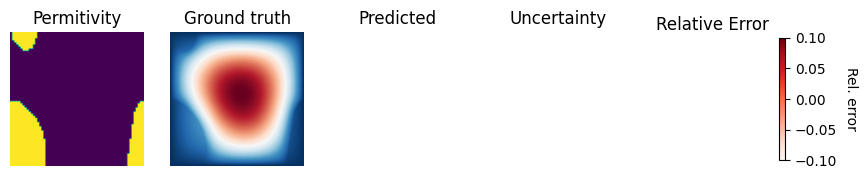

(128, 128)
tf.Tensor(
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]], shape=(128, 128), dtype=float64)


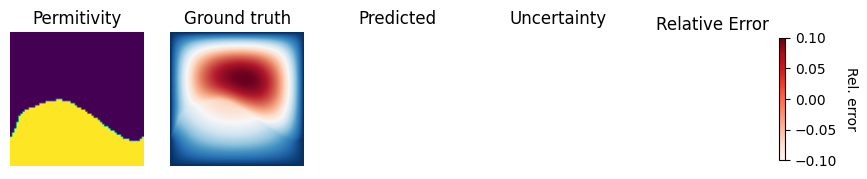

In [ ]:
# import matplotlib.pyplot as plt

# for a, u in test_dataset.take(2):
#     fig, ax = plt.subplots(1, 5, figsize=(10, 5))
    
#     u_pred, std = est_IP(a[None, ...])
#     u_pred, std = u_pred, std
#     u_pred = tf.reshape(u_pred, (128,128))
#     std = tf.reshape(std, (128,128))

#     ax[0].imshow(tf.reshape(a, (64, 64)), cmap = "viridis")
#     ax[0].set_axis_off()
#     ax[0].set_title("Permitivity")
#     ax[1].imshow(u, cmap = "RdBu_r")
#     ax[1].set_axis_off()
#     ax[1].set_title("Ground truth")
#     ax[2].imshow(u_pred, cmap = "RdBu_r")
#     ax[2].set_axis_off()
#     ax[2].set_title("Predicted")
#     ax[3].imshow(std, cmap = "GnBu")
#     ax[3].set_axis_off()
#     ax[3].set_title("Uncertainty")

#     u = tf.cast(u, dtype=tf.float32)  # Cast u to float32
#     u_pred = tf.cast(u_pred, dtype=tf.float32) 
#     im3 = ax[4].imshow(np.abs(u_pred - u)**2 / np.max(u**2), cmap = "Reds")
#     ax[4].set_axis_off()
#     ax[4].set_title("Relative Error")
#     cbar = fig.colorbar(im3, ax=ax[4], orientation="vertical", fraction=0.046, pad=0.04)
#     cbar.set_label('Rel. error', rotation=270, labelpad=15)
#     plt.show()

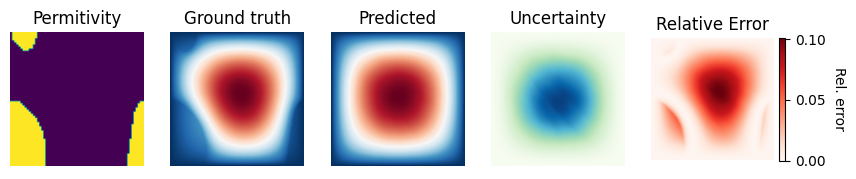

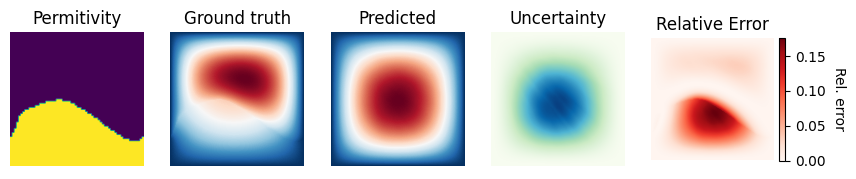

2024-11-18 16:36:18.949839: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# for a, u in test_dataset.take(2):
#     fig, ax = plt.subplots(1, 5, figsize=(10, 5))
    
#     u_pred, std = est_DP(a[None, ...])
#     u_pred, std = u_pred, std
#     u_pred = tf.reshape(u_pred, (128,128))
#     std = tf.reshape(std, (128,128))
    
#     ax[0].imshow(tf.reshape(a, (64, 64)), cmap = "viridis")
#     ax[0].set_axis_off()
#     ax[0].set_title("Permitivity")
#     ax[1].imshow(u, cmap = "RdBu_r")
#     ax[1].set_axis_off()
#     ax[1].set_title("Ground truth")
#     ax[2].imshow(u_pred, cmap = "RdBu_r")
#     ax[2].set_axis_off()
#     ax[2].set_title("Predicted")
#     ax[3].imshow(std, cmap = "GnBu")
#     ax[3].set_axis_off()
#     ax[3].set_title("Uncertainty")

#     u = tf.cast(u, dtype=tf.float32)  # Cast u to float32
#     u_pred = tf.cast(u_pred, dtype=tf.float32) 
#     im3 = ax[4].imshow(np.abs(u_pred - u)**2 / np.max(u**2), cmap = "Reds")
#     ax[4].set_axis_off()
#     ax[4].set_title("Relative Error")
#     cbar = fig.colorbar(im3, ax=ax[4], orientation="vertical", fraction=0.046, pad=0.04)
#     cbar.set_label('Rel. error', rotation=270, labelpad=15)
#     plt.show()